<a href="https://colab.research.google.com/github/sp-au-mu-nl/SpeechComm/blob/main/notebook/chap08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/src/spcom.py
!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap08.zip
!unzip -o chap08.zip
!rm chap08.zip
!wget http://kotoba.slp.k.hosei.ac.jp/~itou/book/2025/SpeechComm/data/CVSPtrain.tgz
!tar xzf CVSPtrain.tgz
!rm CVSPtrain.tgz

--2025-04-23 04:06:44--  https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/src/spcom.py
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/src/spcom.py [following]
--2025-04-23 04:06:44--  https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/src/spcom.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4434 (4.3K) [text/plain]
Saving to: ‘spcom.py’

spcom.py            100%[===================>]   4.33K  --.-KB/s    in 0s      

2025-04-23 04:06:44 (50.3 MB/s) - ‘spcom.py’ saved [4434/4434]

--2025-04-23 04:06:44--  https://githu

プログラム 8.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import librosa
from sklearn.mixture import GaussianMixture

#import spcom

プログラム 8.2

In [3]:
vowels = ['a','i','ɯ','e','o']
CLIP_FOLDER = './train/mp3/'
dfSegment = pd.read_csv('FormantCVTrainShort.csv')
files = dfSegment['Filename'].unique()
fs = 16000
nFFT = int(2 ** np.ceil(np.log2(0.02*fs)))
nShift = int(np.round(0.01*fs))
GMM = {}; nSegment = 0; nMFCC = 13
for v in vowels:
    mfcc = np.empty((nMFCC,0))
    for f in files:
        mp3File = CLIP_FOLDER + f + '.mp3'
        segment = dfSegment.query('Filename==@f & Vowel==@v')
        nSegment += segment.shape[0]
        for b, e in zip(segment['Begin'], segment['End']):
            x, _ = librosa.load(mp3File, offset=b, duration=e-b, sr=fs)
            x = signal.lfilter([1, -0.97], 1, x)
            if len(x) < nFFT:
                x = np.concatenate([x, np.zeros((nFFT-len(x),))])
            m = librosa.feature.mfcc(y=x, hop_length=nShift, sr=fs,
                                     n_fft=nFFT, n_mels=40,
                                     window=np.hanning(nFFT),
                                     n_mfcc=nMFCC, center=False)
            m[0] = 0
            mfcc = np.hstack((mfcc,m))
    GMM[v] = GaussianMixture(n_components=5,
                             covariance_type='diag').fit(mfcc.T)

プログラム 8.3

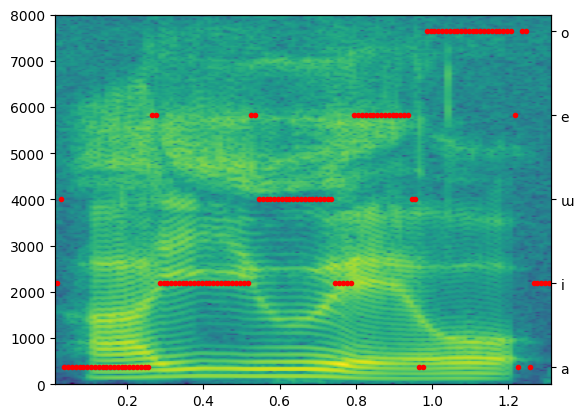

In [4]:
plt.close()
yAiueo, fs = librosa.load('aiueo16k.wav', sr=16000)
yAiueo = signal.lfilter([1, -0.97], 1, yAiueo)
m = librosa.feature.mfcc(y=yAiueo, hop_length=nShift, sr=fs, n_fft=nFFT,
                         window=np.hanning(nFFT), n_mels=40, n_mfcc=nMFCC,
                         center=False)
like = np.zeros((m.shape[1],5))
for vidx, v in enumerate(GMM.keys()):
    like[:,vidx] = GMM[v].score_samples(m.T)
fig, ax1 = plt.subplots()
_,f,t,_=plt.specgram(yAiueo,Fs=fs,NFFT=nFFT,
             window=np.hanning(nFFT),noverlap=nFFT-nShift)
ax2 = ax1.twinx()
ax2.plot(t,(np.argmax(like,axis=1)+1),'ro',markersize=3)
ax2.set_yticks(np.arange(1,6),labels=vowels)

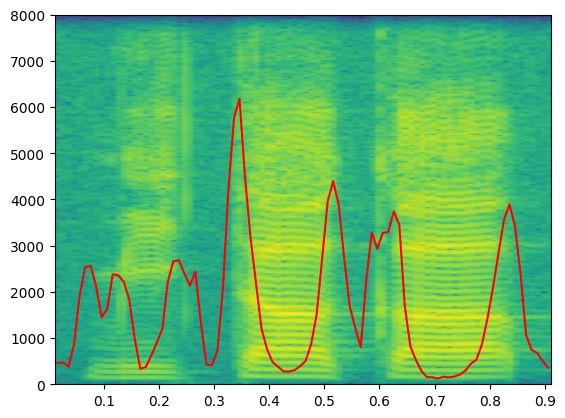

In [5]:
plt.close()
yMitaka, sr = librosa.load('mitaka48k.wav', sr=16000)
yMitaka = signal.lfilter([1, -0.97], 1, yMitaka)
nFFT = 512; nShift = 160
SMitaka, f, t, _ = plt.specgram(yMitaka,Fs=sr,NFFT=nFFT,
                                window=np.hanning(nFFT),
                                noverlap=nFFT-nShift)
mfcc = librosa.feature.mfcc(y=yMitaka, hop_length=nShift, sr=sr,
                            n_fft=nFFT, window=np.hanning(nFFT),
                            n_mels=40, n_mfcc=13, center=False)
mfcc = np.hstack((mfcc[:,0:1], mfcc[:,0:1], mfcc,
                  mfcc[:,-1:], mfcc[:,-1:]))
#x = np.hstack((np.ones((5,1)), np.array([np.arange(5)+1]).T))
x = np.hstack((np.ones((5,1)), np.array([np.arange(5)-2]).T))
dMFCC = np.empty((13,0))
for iColumn in np.arange(2, mfcc.shape[1]-2):
    y = mfcc[:, iColumn-2:iColumn+3]
    b = np.linalg.pinv(x)@(y.T)
    dMFCC = np.hstack((dMFCC, b[1:,:].T))
plt.plot(t,np.linalg.norm(dMFCC, axis=0)*100,'r')
fig = plt.gcf()
fig.savefig('fig08_06.eps')

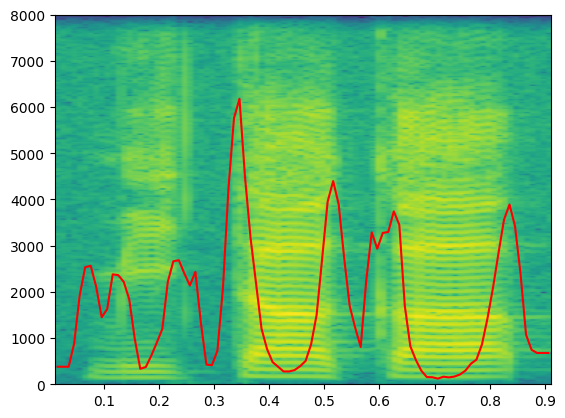

In [6]:
plt.close()
plt.specgram(yMitaka,Fs=sr,NFFT=nFFT,
             window=np.hanning(nFFT),noverlap=nFFT-nShift)
plt.plot(t,np.linalg.norm(librosa.feature.delta(mfcc[:,2:-2],width=5),axis=0)*100,'r')

In [7]:
plt.close()
yMitaka, sr = librosa.load('mitaka48k.wav', sr=16000)
nFFT = 512
nShift = 160
SMitaka = librosa.stft(yMitaka, n_fft=nFFT, hop_length=nShift,
                       window=np.hanning(nFFT), center=False)
t = np.arange(0, len(yMitaka), nShift)/sr
logPower = np.log(np.sum(np.abs(SMitaka)**2,0))
dLogPower = librosa.feature.delta(logPower,width=5)
tYMitaka = np.arange(len(yMitaka))/sr